In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Data

In [ ]:
data_withid = pd.read_csv("tb_pred_achat_new30d.csv",sep=';').drop(['birthdate','membercreationdate','rk','membre_multi_crea_panier'],axis=1)
data = data_withid.drop(['memberid'],axis=1)
data.head()

In [ ]:
data.describe()

In [ ]:
data.info()

In [ ]:
# Variables manquantes
pd.isnull(data).sum()

# Preparation des données

In [ ]:
# Variable endogène
    # Comptage
print(data['ftb12m'].value_counts())
print(data['ftb12m'].value_counts()/data['ftb12m'].count())
    # Graph
print(sns.countplot(data['ftb12m']))

In [ ]:
# Gender
    # Comptage
print(data['gendername'].value_counts())
print(data['gendername'].value_counts()/data['gendername'].count())
    # dummy Female vs Male 1/0
data['female'] = np.where(data['gendername'] == 'Female',1,0)
data.drop(['gendername'],axis=1,inplace=True)
    # Graph
print(sns.countplot(data['female']))

In [ ]:
# Prepa Type_name + drop levier et canal
    # Comptage
print(data['type_name'].value_counts())
    # Graph
print(sns.countplot(data['type_name']))
    # Regroupement "NATUREL" et "CRM" ET "PAYANT" et "AUTRE"
data['organic'] = np.where(data['type_name'] == 'NATUREL',1,0)
data['organic'] = np.where(data['type_name'] == 'CRM',1,data['organic'])
data.drop(['type_name','levier_name','canal_recrutementname'],axis=1,inplace=True)
print(data['organic'].value_counts())

In [ ]:
# Comptages
print(data['app_owner'].value_counts())
print(data['membre_crea_panier'].value_counts())

In [ ]:
data.head(1)

In [ ]:
X

In [ ]:
# Age
    # Histogramme original
print(data['age'].plot(kind='hist',bins=50,figsize=((12,6))))
    # Remplacement des manquants par la médiane
from sklearn.preprocessing import Imputer
print(data['age'].mean())
print(data['age'].median())
imputer = Imputer(strategy="median")
imputer.fit(data.as_matrix())
X = imputer.transform(data.as_matrix())
data_tr = pd.DataFrame(X,columns=data.columns)
    # Histogramme new
print(data_tr['age'].plot(kind='hist',bins=50,figsize=((12,6))))    

In [ ]:
data_tr.info()

# Gestion de la multi-colinéarité

## 1. Matrice des correlations

In [ ]:
corr = data_tr.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# Drop variables pour éviter multi-colinéarité
data_tr2 = data_tr.drop(['visiteur_all','multi_visiteur_all','nb_ventes_visitees','optin_emails_invitation','abandonniste'],axis=1)
data_tr2.columns

In [ ]:
corr = data_tr2.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## 2. VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_tr2.values, i) for i in range(data_tr2.shape[1])]
vif["features"] = data_tr2.columns
vif.round(1)

# Modèle

## Echantillon + rééquilibrage de l'échantillon d'apprentissage

In [ ]:
y = data_tr2['ftb12m']
X = data_tr2.drop(['ftb12m'],axis=1)
print(y.value_counts())
print(y.value_counts()/y.count())

In [ ]:
# Echantillon train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Rééquilibrage des données
from sklearn.utils import resample

df_train = pd.concat([X_train,y_train],axis=1)

df_buyer = df_train[df_train['ftb12m'] == 1]
df_Nbuyer = df_train[df_train['ftb12m'] == 0]

buyer_upsample = resample(df_buyer,replace=True,n_samples=len(df_Nbuyer),random_state=1990)
df_train_upsampled = pd.concat([buyer_upsample,df_Nbuyer])

print(df_train_upsampled['ftb12m'].value_counts())
print(df_train_upsampled['ftb12m'].value_counts()/df_train_upsampled['ftb12m'].count())

y_train_upsampled = df_train_upsampled['ftb12m']
X_train_upsampled = df_train_upsampled.drop(['ftb12m'],axis=1)

## Regression logistique avec scikit-learn

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X=X_train_upsampled, y=y_train_upsampled)

y_pred = logreg.predict(X_test)

In [195]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Intercept: ' + str(logreg.intercept_))
print('Regression: ' + str(logreg.coef_))
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Intercept: [-1.49401417]
Regression: [[-0.00539077  0.23701078  0.22725689  0.00142961  0.44142258  0.15102509
   0.42583808  0.25380457  0.24424043]]
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86     59349
         1.0       0.23      0.56      0.32      6651

   micro avg       0.76      0.76      0.76     66000
   macro avg       0.58      0.67      0.59     66000
weighted avg       0.87      0.76      0.80     66000



Text(0.5, 12.5, 'Predicted label')

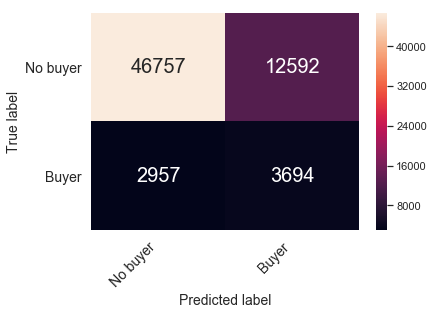

In [196]:
confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No buyer', 'Buyer'), ('No buyer', 'Buyer'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

In [197]:
from sklearn.metrics import roc_auc_score
print('AUROC: ' + str(roc_auc_score(y_test, y_pred)))

AUROC: 0.6716182525978966


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Regression logistique avec statsmodels

In [ ]:
import statsmodels.api as sm

X_contant = sm.add_constant(X_train_upsampled)
model = sm.Logit(y_train_upsampled,X_contant.drop(['nb_alertes_marques'],axis=1))

results = model.fit()

In [ ]:
print(results.summary())

In [ ]:
print(results.summary2())

In [ ]:
stat_pred = results.predict(X_test)
stat_pred.shape

In [ ]:
red_logistic = sm.predict_proba(X_test)[:,1]

In [ ]:
from sklearn.metrics import roc_auc_score
print('AUROC: ' + str(roc_auc_score(y_test, stat_pred)))
print(logreg.coef_)
print(logreg.intercept_)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, results.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, results.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Selection de variable

In [ ]:
from sklearn.metrics import mean_squared_error
def fit_reg(X,Y):
    #Fit regression model and return RSS and R squared values
    model_k = LogisticRegression()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared   

fit_reg(X_train_upsampled,y_train_upsampled)

In [ ]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import itertools

#Initialization variables
Y = y_train_upsampled
X = X_train_upsampled
k = 8
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [ ]:
df.sort_values('R_squared')

## Logistic regression with standardization

In [192]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_upsampled)
X_test_scale = scaler.fit_transform(X_test)

In [194]:
from sklearn.linear_model import LogisticRegression

logreg_scale = LogisticRegression()
logreg_scale.fit(X=X_train_scale, y=y_train_upsampled)

y_pred_scale = logreg_scale.predict(X_test_scale)

C:\Users\rrespriget\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


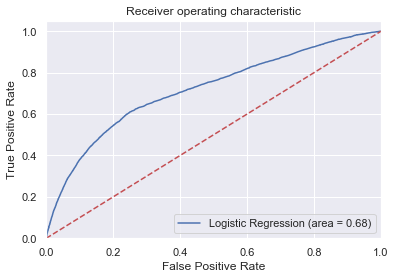

In [199]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg_scale.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_scale.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()